In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import scanpy as sc
import scvelo as scv
import random
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from scipy.special import kl_div

SEED = 2024
np.random.seed(SEED)
random.seed(SEED)

In [2]:
celltype_palette = {
    'HSC':'#d62728',
    'MPP':'#ad494a',
    'CMP':'#1f77b4',
    'GMP':'#aec7e8',
    'MEP':'#ff7f0e',
    'MKP':'#ff9896',
    'EryP':'#ffbb78',
    'MDP':'#8c6d31',
    'Mono':'#c49c94',
    'LMPP':'#aa40fc',
    'CLP':'#c5b0d5',
    'ProB':'#98df8a'}
    
methods = ['velocyto',
           'scvelo_stochastic','scvelo_dynamical',
           'veloAE',
           'Dynamo',
           'veloVAE',
           'multivelo',
           'uniTvelo',
           'DeepVelo_SA',
           'cellDancer',
           'phylovelo',
           'veloVI',
           'latentvelo',# 'latentvelo_latent', # run in local
           "DeepVelo_GB",
           'TFvelo',
           "stt",
           ]

method_replacements = {
    "Velocyto": "velocyto",
    "scvelo_stochastic": "scVelo(sto)",
    "scvelo_dynamical": "scVelo(dyn)",
    "veloAE": "VeloAE",
    "Dynamo_deterministic": "dynamo",
    "veloVAE": "VeloVAE",
    "UniTvelo": "UniTVelo",
    "DeepVelo_SA": "DeepVelo(VAE)",
    "Celldancer": "cellDancer",
    "velovi": "veloVI",
    "Latentvelo": "LatentVelo",
    "DeepVelo_GB": "DeepVelo(GCN)",
    "stt": "STT",
    "multivelo": "MultiVelo",
    "phylovelo": "PhyloVelo",
    "tfvelo": "TFvelo"}

# vkey = {'velocyto':'velocity',
#         'scvelo_stochastic':'velocity','scvelo_dynamical':'velocity',
#         'veloAE':'new_velocity',
#         'Dynamo':'velocity_S',
#         'veloVAE':'vae_velocity',
#         'uniTvelo':'velocity',
#         'DeepVelo_SA':'velocity_dv',
#         'cellDancer':'velocity_S',
#         'veloVI':'velocity',
#         'latentvelo':'velo','latentvelo_latent':'velo',
#         'DeepVelo_GB':'velocity',
#         'multivelo':'velo_s',
#         'TFvelo':'velocity',
#         'TFvelo2':'velocity',
#         'stt':'velocity'}


In [3]:
adata_HSPC = sc.read_h5ad("adata/redeem_young.h5ad")
print(adata_HSPC)

AnnData object with n_obs × n_vars = 9144 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'seurat_clusters', 'Sig.HSC1', 'Sig.Prog1', 'Sig.EarlyE1', 'Sig.LateE1', 'Sig.ProMono1', 'Sig.Mono1', 'Sig.ncMono1', 'Sig.cDC1', 'Sig.pDC1', 'Sig.ProB1', 'Sig.PreB1', 'Sig.B1', 'Sig.Plasma1', 'Sig.T1', 'Sig.CTL1', 'Sig.NK1', 'STD.CellType', 'STD_Cat', 'STD_Cat2', 'Sample', 'MitoCoverage', 'ClonalGroup', 'ClonalGroup.Prob', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'nCount_ambiguous', 'nFeature_ambiguous', 'CellType', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'name', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'CellType_colors', 'STD.CellType_colors', 'neighbors', 'umap', 'velocity_gra

velocyto
scvelo_stochastic
scvelo_dynamical
veloAE
Dynamo
veloVAE
multivelo
uniTvelo
DeepVelo_SA
cellDancer
phylovelo
veloVI
latentvelo
DeepVelo_GB
TFvelo
        Consider computing the graph in an unbiased manner 
        on full expression space by not specifying basis.

computing velocity graph (using 26/52 cores)


  0%|          | 0/9144 [00:00<?, ?cells/s]

    finished (0:00:14) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
stt


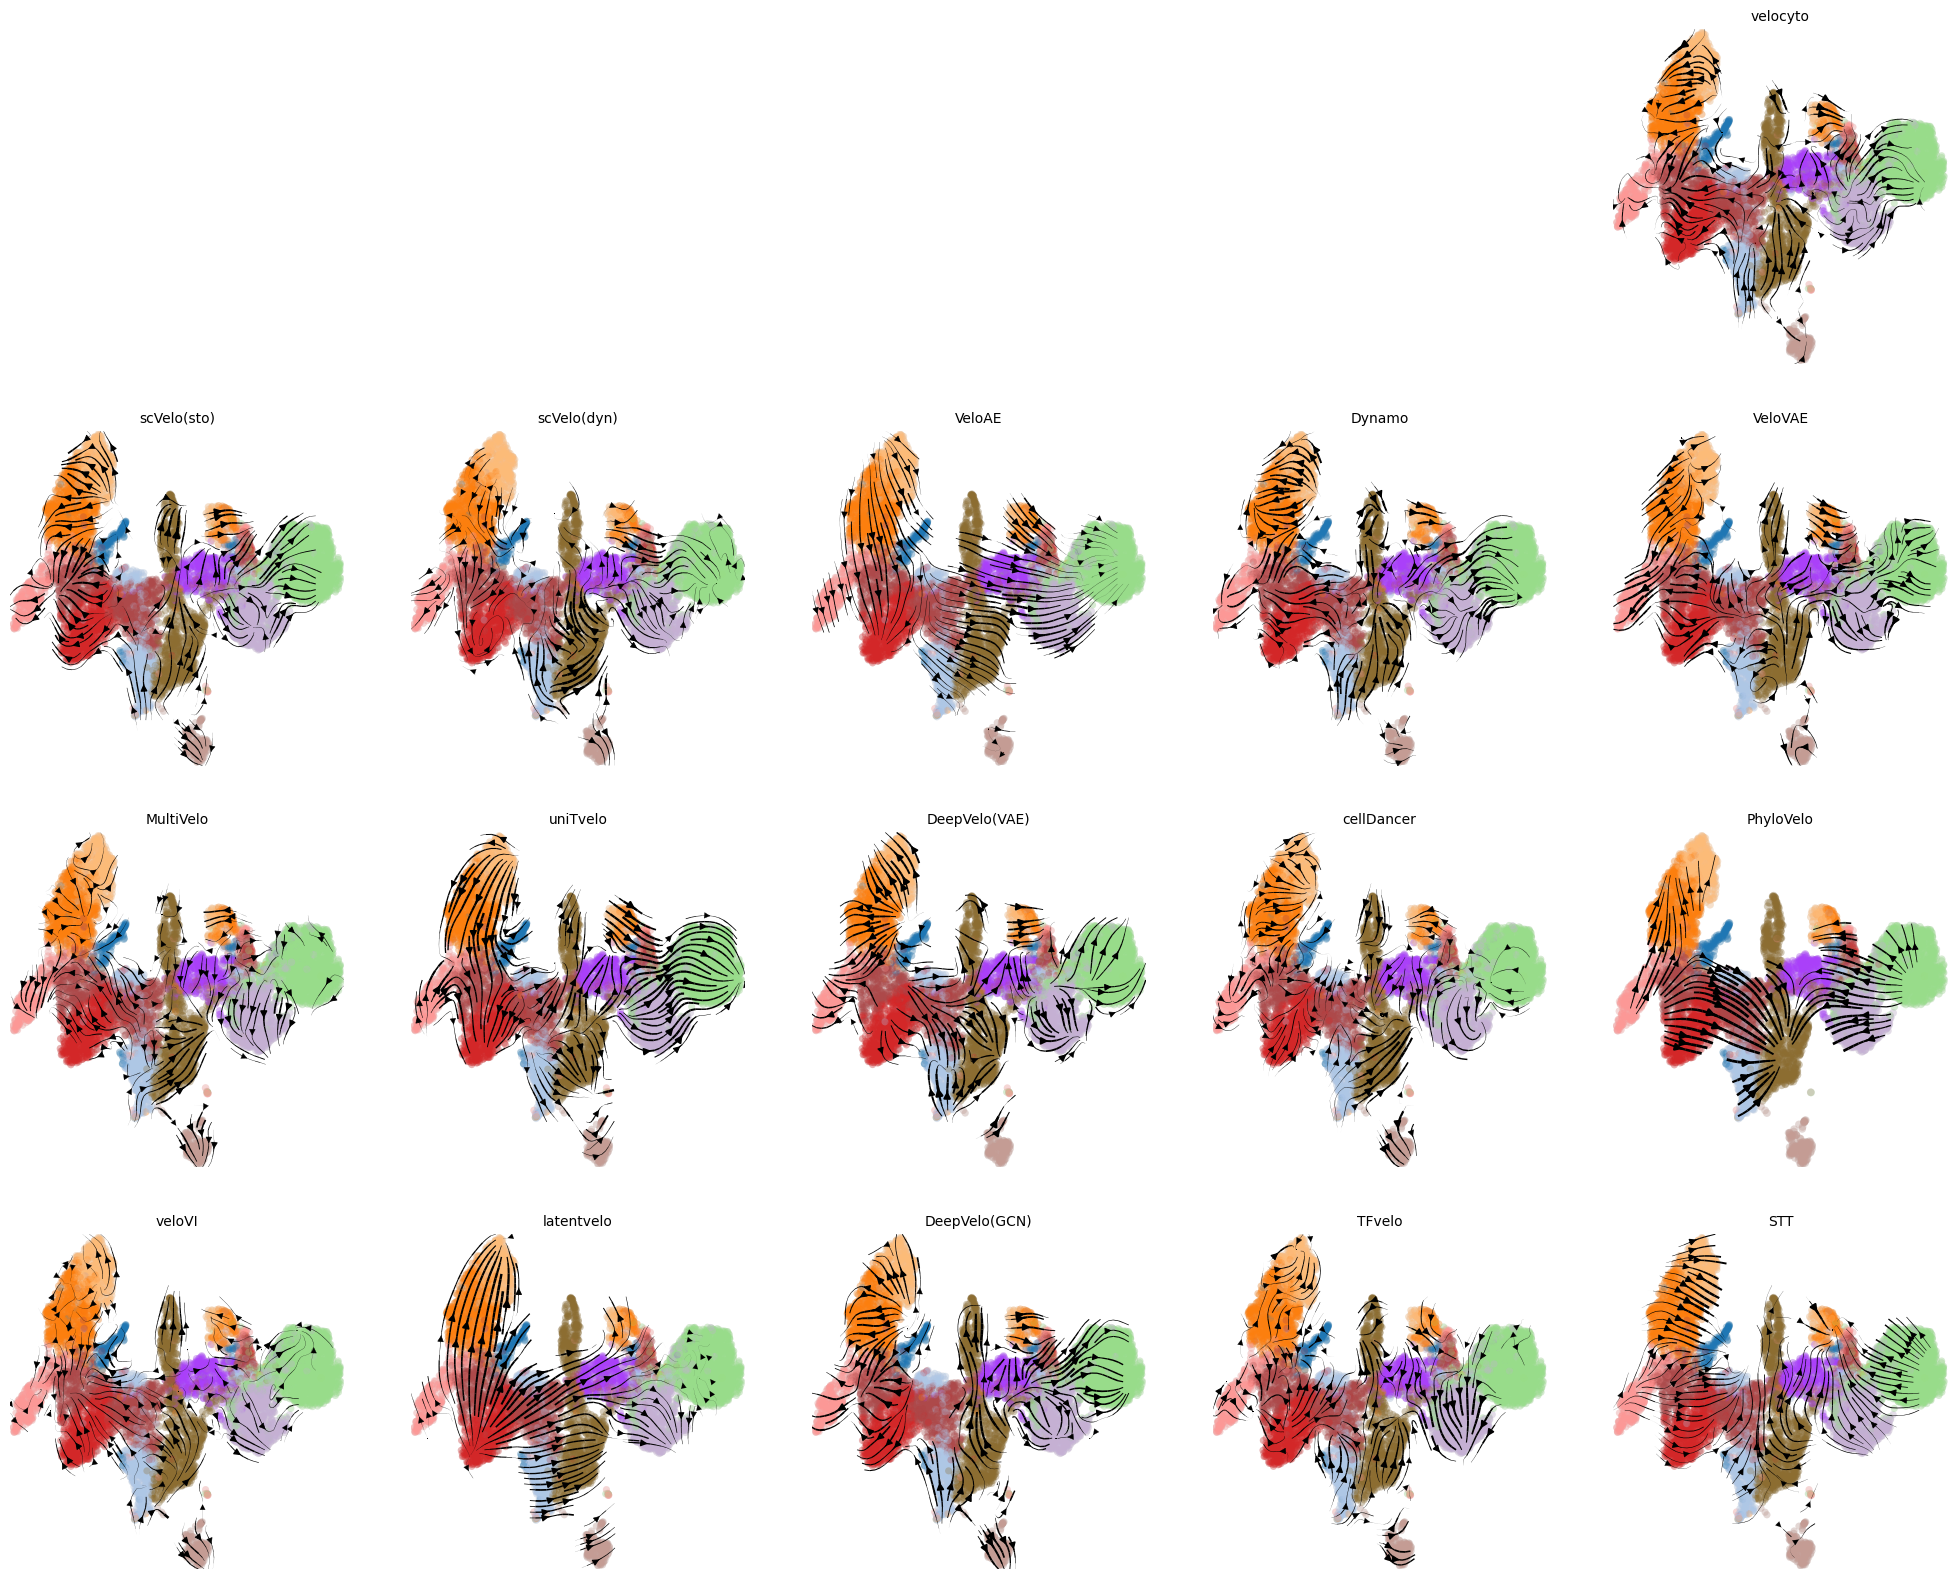

In [4]:
nrow = 4
ncol = 5
fig, axs = plt.subplots(nrow, ncol, figsize=(5 * ncol, 5 * nrow))

# blank
for f in range(0,4):
    r = int(f/ncol)
    c = f % ncol
    ax = axs[r, c]
    ax.set_visible(False)
    ax.set_facecolor('none')

f = 4 
for m in methods:
    print(m)

    r = int(f/ncol)
    c = f % ncol
    ax = axs[r, c]

    adata = sc.read_h5ad("adata/adata_umap_graph/" + m + ".h5ad")

    if m in method_replacements.keys():
        title_name = method_replacements[m]
    else:
        title_name = m

    if m == 'TFvelo':
        n_cells = adata.shape[0]
        expanded_scaling_y = np.expand_dims(np.array(adata.var['fit_scaling_y']),0).repeat(n_cells,axis=0)
        adata.layers['velocity'] = adata.layers['velo_hat'] / expanded_scaling_y
        scv.tl.velocity_graph(adata,vkey="velocity",n_jobs=26,basis= "umap")

    scv.pl.velocity_embedding_stream(adata,basis= 'umap',color="CellType",ax = ax,
                                vkey='velocity',# recompute=True,
                                groups = ['HSC','MPP','CMP','GMP','MEP','MKP','EryP',
                                        'MDP','Mono',
                                        'LMPP','CLP','ProB'],
                                palette = celltype_palette,
                                title=title_name,# title="",
                                show=False,legend_loc='none',frameon=False,
                                # linewidth = 1,
                                # save="Figure/" + m +".svg" 
                                )
    
    ax.axis('off')
    ax.tick_params(top="off",bottom="off",left="off",right="off",labelleft="off",labelbottom="off")

    f = f+1

plt.savefig('Figure/merge_stream_300_with_title.png',bbox_inches='tight',format='png',dpi=300)

velocyto
scvelo_stochastic
scvelo_dynamical
veloAE
Dynamo
veloVAE
multivelo
uniTvelo
DeepVelo_SA
cellDancer
phylovelo
veloVI
latentvelo
DeepVelo_GB
TFvelo
        Consider computing the graph in an unbiased manner 
        on full expression space by not specifying basis.

computing velocity graph (using 26/52 cores)


  0%|          | 0/9144 [00:00<?, ?cells/s]

    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
stt


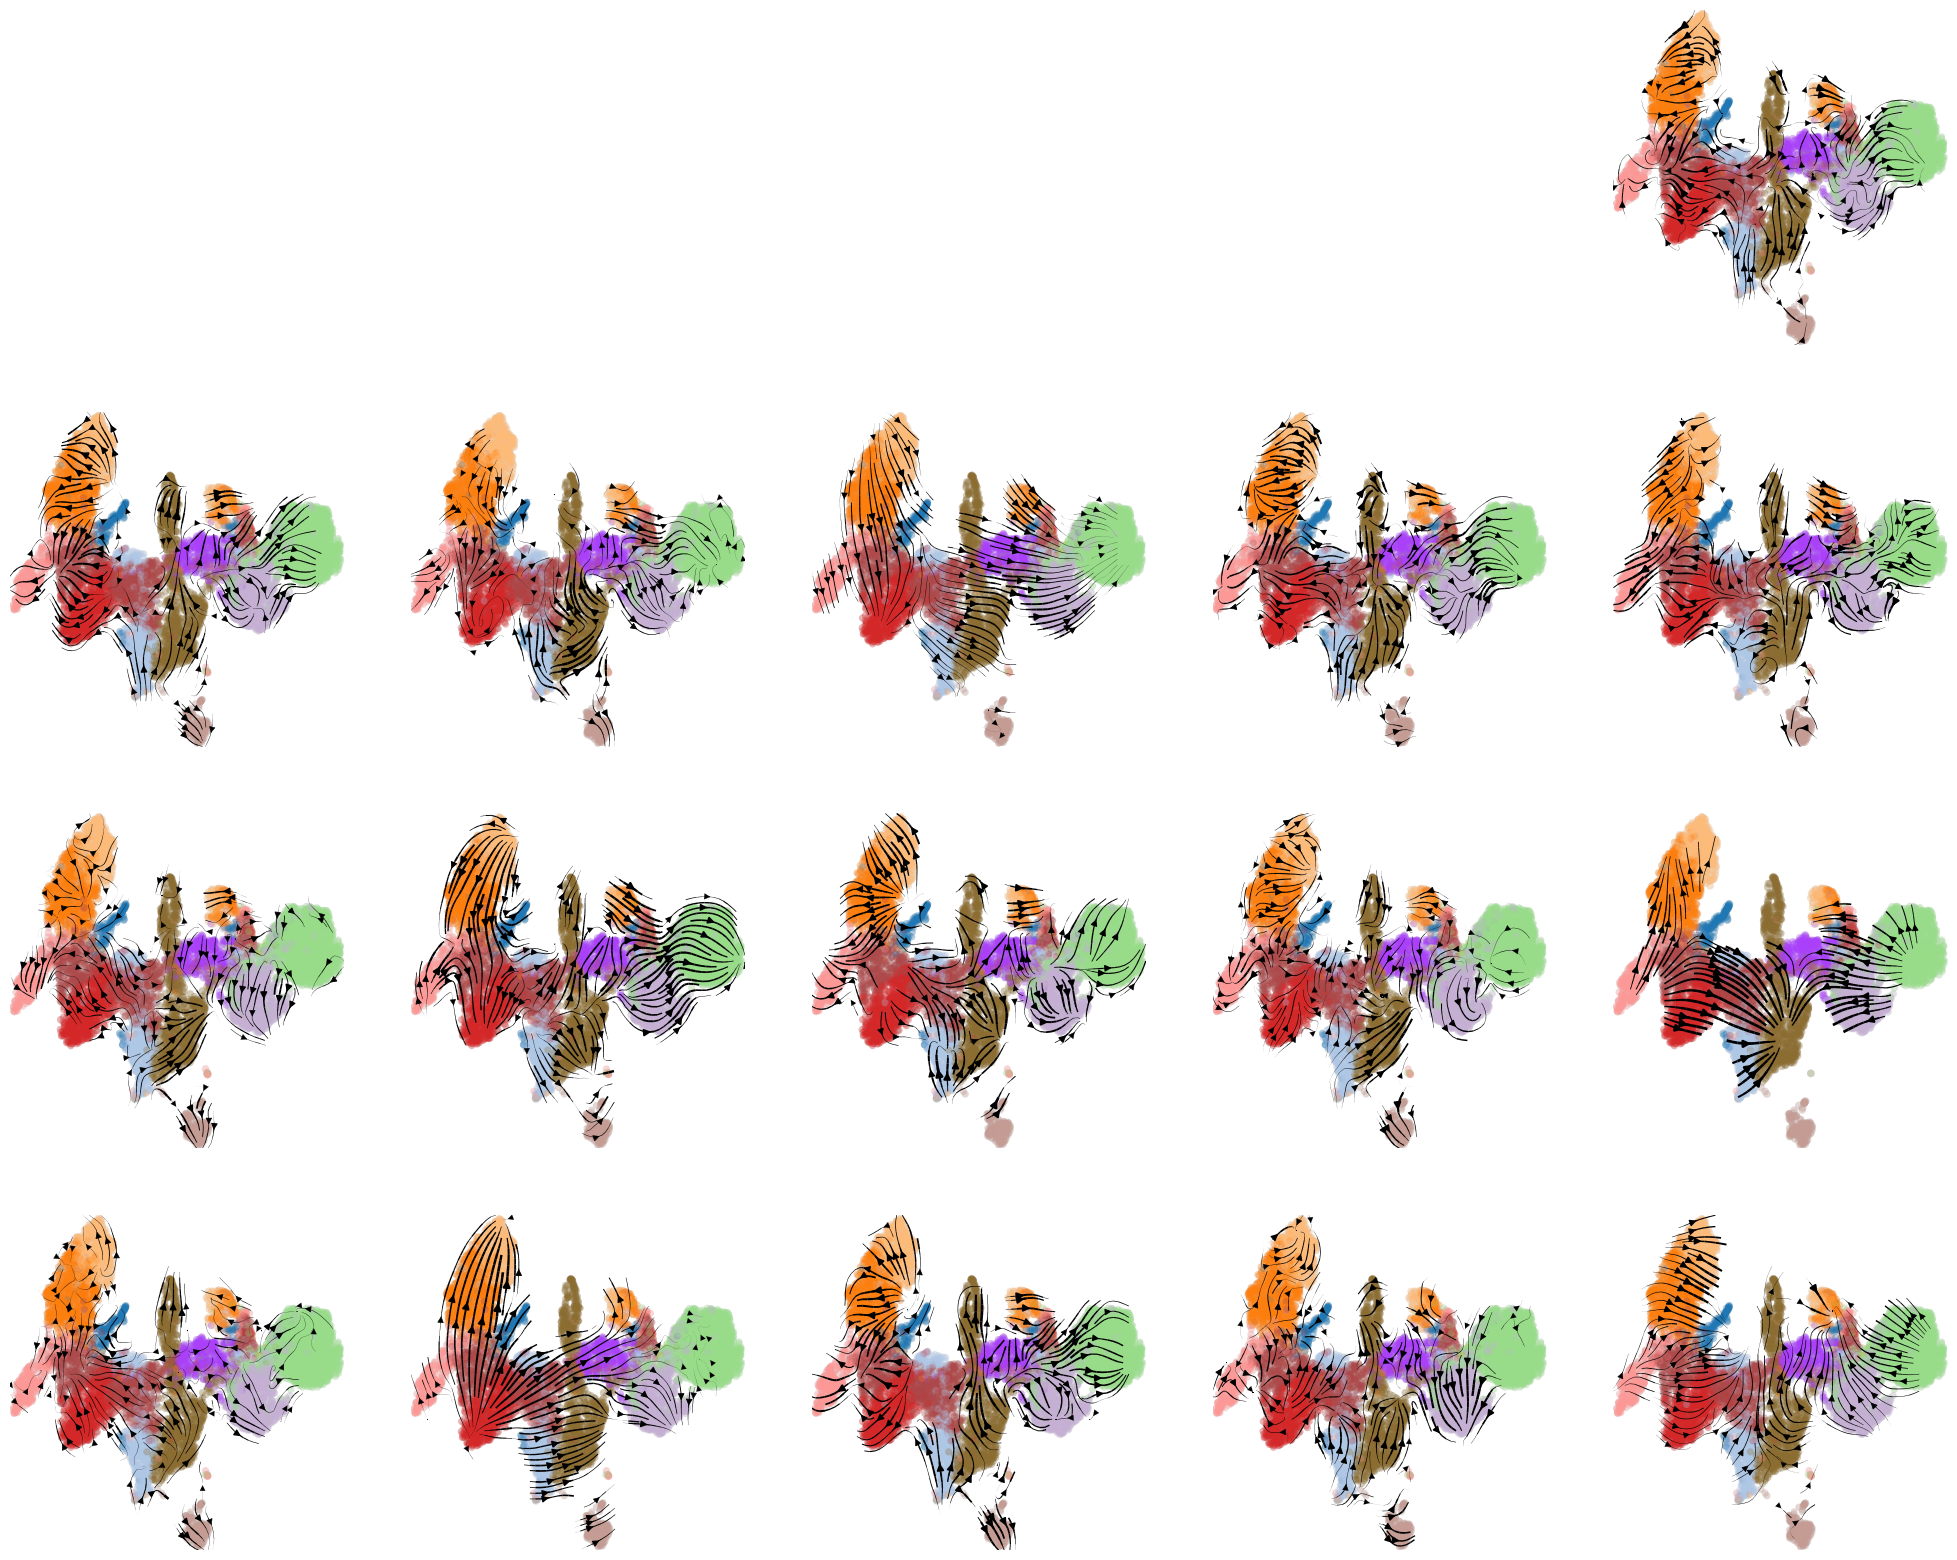

In [5]:
nrow = 4
ncol = 5
fig, axs = plt.subplots(nrow, ncol, figsize=(5 * ncol, 5 * nrow))

# blank
for f in range(0,4):
    r = int(f/ncol)
    c = f % ncol
    ax = axs[r, c]
    ax.set_visible(False)
    ax.set_facecolor('none')

f = 4 
for m in methods:
    print(m)

    r = int(f/ncol)
    c = f % ncol
    ax = axs[r, c]

    adata = sc.read_h5ad("adata/adata_umap_graph/" + m + ".h5ad")

    if m in method_replacements.keys():
        title_name = method_replacements[m]
    else:
        title_name = m

    if m == 'TFvelo':
        n_cells = adata.shape[0]
        expanded_scaling_y = np.expand_dims(np.array(adata.var['fit_scaling_y']),0).repeat(n_cells,axis=0)
        adata.layers['velocity'] = adata.layers['velo_hat'] / expanded_scaling_y
        scv.tl.velocity_graph(adata,vkey="velocity",n_jobs=26,basis= "umap")

    scv.pl.velocity_embedding_stream(adata,basis= 'umap',color="CellType",ax = ax,
                                vkey='velocity',# recompute=True,
                                groups = ['HSC','MPP','CMP','GMP','MEP','MKP','EryP',
                                        'MDP','Mono',
                                        'LMPP','CLP','ProB'],
                                palette = celltype_palette,
                                # title=title_name,
                                title="",
                                show=False,legend_loc='none',frameon=False,
                                # linewidth = 1,
                                # save="Figure/" + m +".svg" 
                                )
    
    ax.axis('off')
    ax.tick_params(top="off",bottom="off",left="off",right="off",labelleft="off",labelbottom="off")

    f = f+1

plt.savefig('Figure/merge_stream.svg',bbox_inches='tight',format='svg')
plt.savefig('Figure/merge_stream_600.png',bbox_inches='tight',format='png',dpi=600)
plt.savefig('Figure/merge_stream_300.png',bbox_inches='tight',format='png',dpi=300)
plt.show()

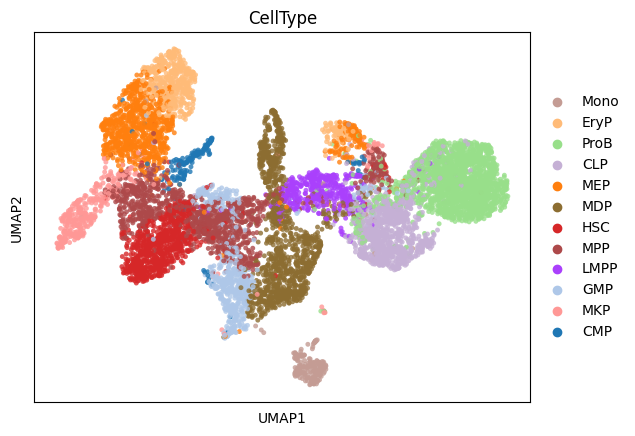

In [6]:
sc.pl.umap(adata,color="CellType",size=50,alpha=0.8,
           groups = ['HSC','MPP','CMP','GMP','MEP','MKP','EryP',
                                        'MDP','Mono',
                                        'LMPP','CLP','ProB'],palette = celltype_palette,
                                        save='umap.pdf')